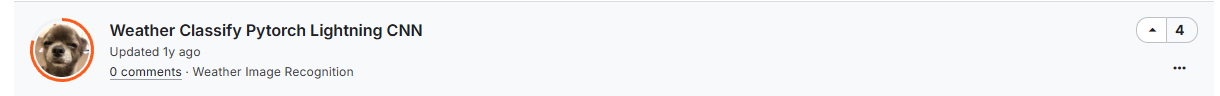

In [1]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import random_split, SubsetRandomSampler
from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
import pytorch_lightning as pl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image

In [2]:
transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [4]:
data_path = 'D:\code_study\ML_CODE\dataSets\Weather_Image_Recognition\dataset'
class_names=sorted(os.listdir(data_path))
class_names

['dew',
 'fogsmog',
 'frost',
 'glaze',
 'hail',
 'lightning',
 'rain',
 'rainbow',
 'rime',
 'sandstorm',
 'snow']

In [5]:
class DataModule(pl.LightningDataModule):
    
    def __init__(self, transform=transform, batch_size=32):
        super().__init__()
        self.root_dir = data_path
        self.transform = transform
        self.batch_size = batch_size

    def setup(self, stage=None):
        dataset = datasets.ImageFolder(root=self.root_dir, transform=self.transform)
        n_data = len(dataset)
        n_train = int(0.5 * n_data)
        n_valid = int(0.2 * n_data)
        n_test = n_data - n_train - n_valid

        train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [n_train, n_valid, n_test])

        self.train_dataset = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        self.val_dataset = DataLoader(val_dataset, batch_size=self.batch_size)
        self.test_dataset = DataLoader(test_dataset, batch_size=self.batch_size)
        
    def train_dataloader(self):
        return self.train_dataset
    
    def val_dataloader(self):
        return self.val_dataset
    
    def test_dataloader(self):
        return self.test_dataset

In [7]:
class ConvolutionalNetwork(LightningModule):
    
    def __init__(self):
        super(ConvolutionalNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(16 * 54 * 54, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)
        self.fc4 = nn.Linear(20, len(class_names))

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16 * 54 * 54)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = self.fc4(X)
        return F.log_softmax(X, dim=1)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("val_loss", loss)
        self.log("val_acc", acc)

    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("test_loss", loss)
        self.log("test_acc", acc)

In [10]:
if __name__ == '__main__':
    datamodule = DataModule()
    datamodule.setup()
    model = ConvolutionalNetwork()
    trainer = pl.Trainer(max_epochs=30)
    trainer.fit(model, datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | conv1 | Conv2d | 168    | train
1 | conv2 | Conv2d | 880    | train
2 | fc1   | Linear | 5.6 M  | train
3 | fc2   | Linear | 10.2 K | train
4 | fc3   | Linear | 1.7 K  | train
5 | fc4   | Linear | 231    | train
-----------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.448    Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 29: 100%|██████████| 108/108 [00:19<00:00,  5.46it/s, v_num=1]       

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 108/108 [00:19<00:00,  5.42it/s, v_num=1]


In [11]:
datamodule.setup(stage='test')
test_loader = datamodule.test_dataloader()
trainer.test(dataloaders=test_loader)

c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\pytorch_lightning\trainer\connectors\checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at d:\code_study\ML_CODE\kaggle\Classfication\Weather Image Recognition\Weather Classify Pytorch Lightning CNN\lightning_logs\version_1\checkpoints\epoch=29-step=3240.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at d:\code_study\ML_CODE\kaggle\Classfication\Weather Image Recognition\Weather Classify Pytorch Lightning CNN\lightning_logs\version_1\checkpoints\epoch=29-step=3240.ckpt
c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataload

Testing DataLoader 0: 100%|██████████| 65/65 [00:08<00:00,  7.71it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8081592917442322     │
│         test_loss         │    0.8604792952537537     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.8604792952537537, 'test_acc': 0.8081592917442322}]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


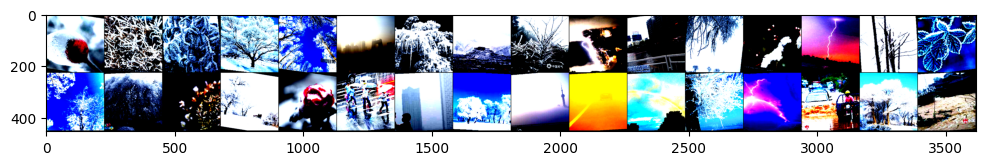

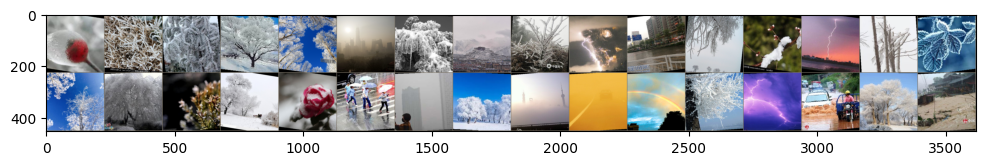

In [12]:
for images, labels in datamodule.train_dataloader():
    break
im=make_grid(images,nrow=16)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                   std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [13]:
device = torch.device("cpu")   #"cuda:0"

model.eval()
y_true=[]
y_pred=[]
with torch.no_grad():
    for test_data in datamodule.test_dataloader():
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

print(classification_report(y_true,y_pred,target_names=class_names,digits=4))

              precision    recall  f1-score   support

         dew     0.9037    0.8009    0.8492       211
     fogsmog     0.9269    0.8120    0.8657       250
       frost     0.6667    0.7704    0.7148       135
       glaze     0.6513    0.6649    0.6580       191
        hail     0.7596    0.7809    0.7701       178
   lightning     0.8687    0.7611    0.8113       113
        rain     0.8561    0.7244    0.7847       156
     rainbow     0.6774    0.6269    0.6512        67
        rime     0.7160    0.9036    0.7989       332
   sandstorm     0.9068    0.9427    0.9244       227
        snow     0.7953    0.6834    0.7351       199

    accuracy                         0.7931      2059
   macro avg     0.7935    0.7701    0.7785      2059
weighted avg     0.8018    0.7931    0.7936      2059

